## Learning Dirichlet boundary data to solution map for Poisson problem (Implementation 1)

The forward problem is based on Poisson equation, and the map of interest is the one that takes Dirichlet boundary condition function to the solution of the PDE. The dmain is a triangular with a notch. The numerical solution and the implementation in Matlab is from the repository [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main). These examples are considered in the references below:

- Goswami, Somdatta, et al. "Physics-informed deep neural operator networks." Machine Learning in Modeling and Simulation: Methods and Applications. Cham: Springer International Publishing, 2023. 219-254.
- Lu, Lu, et al. "Learning nonlinear operators via DeepONet based on the universal approximation theorem of operators." Nature machine intelligence 3.3 (2021): 218-229.

> For the implementation, we only need `Darcy_Triangulation.mat` which is included in the repository. 

> Dependencies can be installed using `neuralop.yml` file in the root directory of this repository. 

Notebook shows the implemntation of DeepONet from the directory [deeponet-fno/src/darcy_triangular_notch
/deeponet](https://github.com/lu-group/deeponet-fno/tree/main/src/darcy_triangular_notch/deeponet) of [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main) library. We made few minor changes but the core implementation is from the mentioned source. The method is based on tensorflow `tensorflow.compat.v1`.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement1/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

# os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import numpy as np
import scipy
import scipy.io as io
import matplotlib.pyplot as plt

# set seed
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

2024-11-04 21:43:46.816628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 21:43:46.836392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 21:43:46.842680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 21:43:46.856771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement1/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Utilities function

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

def field_plot(ax, fn_nodal_values, nodes, elements = None, dim = 2, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    if dbg_log:
        print('fn_nodal_values.shape = {}, nodes.shape = {}'.format(fn_nodal_values.shape, \
                                                                nodes.shape))
    
    n1, n2 = len(fn_nodal_values), 1
    if fn_nodal_values.ndim == 2:
        n2 = fn_nodal_values.shape[1]
    elif fn_nodal_values.ndim > 2: 
        raise ValueError("fn_nodal_values should be a 1D or 2D array")

    if n1 != nodes.shape[0]:
        raise ValueError("Number of nodes in the mesh and the number of dofs do not match")
    
    # Compute magnitude of the field
    C = None
    if fn_nodal_values.ndim == 1:
        C = fn_nodal_values[:]**2
    else:
        for i in range(n2):
            if i == 0:
                C = fn_nodal_values[:, i]**2
            else:
                C += fn_nodal_values[:, i]**2

    C = np.sqrt(C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement:
        if n2 != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        if add_displacement_to_nodes:
            nodes_def = nodes + fn_nodal_values

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = None
    if elements is not None:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    else:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, C, shading=shading, **kwargs)

    return cbar

## Data related methods

In [4]:
class DataProcessor:
    def __init__(self, batch_size, num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601):
        self.batch_size = batch_size
        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points

        self.data, self.X_trunk, self.X_train, self.Y_train, \
            self.X_test, self.Y_test, self.X_train_mean, \
            self.X_train_std, self.Y_train_mean, self.Y_train_std, \
            self.tol = self.load_data()

        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)
    
    def load_data(self, tol = 1.0e-9):
        
        data = io.loadmat(data_folder + 'Darcy_Triangular')

        # trunk input data ('xi' coordinates)
        xx = data['xx']
        yy = data['yy']
        xx = np.reshape(xx, (-1, 1))
        yy = np.reshape(yy, (-1, 1))
        X_trunk = np.hstack((xx, yy))
        
        # branch input data (boundary conditions)
        X_train = data['f_bc'][:self.num_train,:]
        X_test = data['f_bc'][self.num_train:(self.num_train + self.num_test),:]

        X_train_mean = np.mean(np.reshape(X_train, (-1, self.num_inp_fn_points)), 0)
        X_train_mean = np.reshape(X_train_mean, (-1, 1, self.num_inp_fn_points))

        X_train_std = np.std(np.reshape(X_train, (-1, self.num_inp_fn_points)), 0)
        X_train_std = np.reshape(X_train_std, (-1, 1, self.num_inp_fn_points))

        X_train = np.reshape(X_train, (-1, 1, self.num_inp_fn_points))
        X_train = (X_train - X_train_mean)/(X_train_std + tol)

        X_test = np.reshape(X_test, (-1, 1, self.num_inp_fn_points))
        X_test = (X_test - X_train_mean)/(X_train_std + tol)

        # output data (PDE solutions)
        Y_train = data['u_field'][:self.num_train,:]
        Y_test = data['u_field'][self.num_train:(self.num_train + self.num_test),:]
        
        Y_train_mean = np.mean(np.reshape(Y_train, (-1, self.num_out_fn_points)), 0)
        Y_train_mean = np.reshape(Y_train_mean, (-1, self.num_out_fn_points, 1))

        Y_train_std = np.std(np.reshape(Y_train, (-1, self.num_out_fn_points)), 0)
        Y_train_std = np.reshape(Y_train_std, (-1, self.num_out_fn_points, 1))

        Y_train = np.reshape(Y_train, (-1, self.num_out_fn_points, 1))
        Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
        
        Y_test = np.reshape(Y_test, (-1, self.num_out_fn_points, 1))
        Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)
        
        return data, X_trunk, X_train, Y_train, X_test, Y_test, X_train_mean, X_train_std, Y_train_mean, Y_train_std, tol
        
    def minibatch(self):

        batch_id = np.random.choice(self.X_train.shape[0], self.batch_size, replace=False)

        X_train = [self.X_train[i:i+1] for i in batch_id]
        X_train = np.concatenate(X_train, axis=0)
        Y_train = [self.Y_train[i:i+1] for i in batch_id]
        Y_train = np.concatenate(Y_train, axis=0)

        X_trunk_train = self.X_trunk
        X_trunk_min = self.X_trunk_min
        X_trunk_max = self.X_trunk_max

        return X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max

    def testbatch(self, num_test):
        batch_id = np.arange(num_test)
        X_test = [self.X_test[i:i+1] for i in batch_id]
        X_test = np.concatenate(X_test, axis=0)
        Y_test = [self.Y_test[i:i+1] for i in batch_id]
        Y_test = np.concatenate(Y_test, axis=0)
        X_trunk_test = self.X_trunk

        return X_test, X_trunk_test, Y_test
    
    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        return x
    
    def encoder_Y_1d(self, x):    
        x[:] = (x[:] - self.Y_train_mean[0,:,0])/(self.Y_train_std[0,:,0] + self.tol)
        return x

    def decoder_Y(self, x):
        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x
    
    def decoder_Y_1d(self, x):
        # assume x is 1D array
        x[:] = x[:]*(self.Y_train_std[0,:,0] + self.tol) + self.Y_train_mean[0,:,0]
        return x
    
    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        return x
    
    def encoder_X_1d(self, x):    
        x[:] = (x[:] - self.X_train_mean[0,:,0])/(self.X_train_std[0,:,0] + self.tol)
        return x
    
    def decoder_X(self, x):
        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x
    
    def decoder_X_1d(self, x):
        # assume x is 1D array
        x[:] = x[:]*(self.X_train_std[0,:,0] + self.tol) + self.X_train_mean[0,:,0]
        return x

In [5]:
class SaveData:
    def __init__(self):
        pass

    def save(self, sess, X_trunk_pos, fnn_model, W_T, b_T, W_B, b_B, X_trunk_min, X_trunk_max, X_ph, Y_ph, data, num_test, results_dir):
        
        X_test, X_trunk_test, Y_test = data.testbatch(num_test)
        X_trunk = tf.tile(X_trunk_pos[None, :, :], [num_test, 1, 1])
        u_T = fnn_model.fnn_T(W_T, b_T, X_trunk, X_trunk_min, X_trunk_max)
        test_dict = {X_ph: X_test, Y_ph: Y_test}
        u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
        u_B = tf.tile(u_B, [1, X_trunk_test.shape[0], 1])
        u_nn = u_B*u_T
        Y_pred = tf.reduce_sum(u_nn, axis=-1, keepdims=True)
        Y_pred_ = sess.run(Y_pred, feed_dict=test_dict)
        Y_test = data.decoder_Y(Y_test)
        Y_pred_ = data.decoder_Y(Y_pred_)   

        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        Y_pred_ = np.reshape(Y_pred_, (Y_test.shape[0], Y_test.shape[1]))        
        Y_ref = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1]))

        err = np.mean(np.linalg.norm(Y_pred_ - Y_ref, 2, axis=1)/np.linalg.norm(Y_ref, 2, axis=1))
        print('Relative L2 Error: %.3f'%(err))
        err = np.reshape(err, (-1, 1))
        
        np.savetxt(results_dir+'/err.txt', err, fmt='%e')
        
        scipy.io.savemat(results_dir+'darcy_triangular_test_DeepONet.mat', 
                     mdict={'X_test': X_test,
                            'Y_test': Y_test, 
                            'Y_pred': Y_pred_})
        

## Define network methods

In [6]:
class FNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2./(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn_T(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    
    def fnn_B(self, W, b, X):
        A = X
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y

## Load data

In [7]:
num_train = 1900
num_test = 100

num_inp_fn_points = 101 # number of grid points for the input function
num_out_fn_points = 2397 # number of evaluations points for the output function
num_br_tr_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied

#branch net
layer_B = [num_inp_fn_points, 128, 128, num_br_tr_outputs]
#trunk net
layer_T = [2, 128, 128, num_br_tr_outputs]

#batch_size
batch_size = 100
epochs = 1000
lr = 1.0e-3

data = DataProcessor(batch_size, num_train = num_train, num_test = num_test, num_inp_fn_points = num_inp_fn_points, num_out_fn_points = num_out_fn_points)

## Create model and train the network

In [8]:
X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max = data.minibatch()
X_trunk_pos = tf.constant(X_trunk_train, dtype=tf.float32)
X_trunk_tf = tf.tile(X_trunk_pos[None, :, :], [batch_size, 1, 1]) #[bs, x_num, x_dim]

X_ph = tf.placeholder(shape=[None, 1, num_inp_fn_points], dtype=tf.float32) #[bs, f_dim]
Y_ph = tf.placeholder(shape=[None, num_out_fn_points, 1], dtype=tf.float32) #[bs, x_num, 1]
learning_rate = tf.placeholder(tf.float32, shape=[])

fnn_model = FNN()
# Branch net
W_B, b_B = fnn_model.hyper_initial(layer_B)
u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
u_B = tf.tile(u_B, [1, num_out_fn_points, 1])   
#Trunk net
W_T, b_T = fnn_model.hyper_initial(layer_T)
u_T = fnn_model.fnn_T(W_T, b_T, X_trunk_tf, X_trunk_min, X_trunk_max)
#inner product
u_nn = u_B*u_T
Y_pred = tf.reduce_sum(u_nn, axis=-1, keepdims=True)

loss = tf.reduce_mean(tf.square(Y_ph - Y_pred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
saver = tf.train.Saver()
sess = tf.Session()  
sess.run(tf.global_variables_initializer())

n = 0
start_time = time.perf_counter()

train_loss = np.zeros((epochs+1, 1))
test_loss = np.zeros((epochs+1, 1))    

loss_print_freq = 100

while n <= epochs:

    if n < 1000:
        lr = 0.001
    elif n < 5000:
        lr = 0.0005
    else:
        lr = 0.0001
            
    start_time = time.perf_counter()
    X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
    train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
    loss_, _ = sess.run([loss, train], feed_dict=train_dict)
    
    X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
    Y_test_ = sess.run(Y_pred, feed_dict={X_ph: X_test})
    Y_test = data.decoder_Y(Y_test)
    Y_test_ = data.decoder_Y(Y_test_)
    err = np.mean(np.linalg.norm(Y_test_ - Y_test, 2, axis=1)/np.linalg.norm(Y_test, 2, axis=1))
    
    end_time = time.perf_counter()

    epoch_time = end_time - start_time

    if n % loss_print_freq == 0:
        print('='*30)
        print('Epoch: {:5d}, Train Loss (rel l2): {:.3e}, Test Loss (rel l2): {:.3e}, Time (sec): {:.3f}'.format(n, loss_, err, epoch_time))
        print('='*30)

    train_loss[n,0] = loss_
    test_loss[n,0] = err
    n += 1

I0000 00:00:1730781830.697869   13047 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730781830.754345   13047 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730781830.754649   13047 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730781830.758841   13047 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch:     0, Train Loss (rel l2): 8.730e-01, Test Loss (rel l2): 8.271e-01, Time (sec): 0.427
Epoch:   100, Train Loss (rel l2): 4.106e-02, Test Loss (rel l2): 1.686e-01, Time (sec): 0.043
Epoch:   200, Train Loss (rel l2): 3.517e-02, Test Loss (rel l2): 1.421e-01, Time (sec): 0.039
Epoch:   300, Train Loss (rel l2): 2.556e-02, Test Loss (rel l2): 1.231e-01, Time (sec): 0.038
Epoch:   400, Train Loss (rel l2): 4.689e-02, Test Loss (rel l2): 1.441e-01, Time (sec): 0.042
Epoch:   500, Train Loss (rel l2): 2.208e-02, Test Loss (rel l2): 1.029e-01, Time (sec): 0.043
Epoch:   600, Train Loss (rel l2): 1.847e-02, Test Loss (rel l2): 9.687e-02, Time (sec): 0.038
Epoch:   700, Train Loss (rel l2): 2.101e-02, Test Loss (rel l2): 9.028e-02, Time (sec): 0.039
Epoch:   800, Train Loss (rel l2): 1.902e-02, Test Loss (rel l2): 8.761e-02, Time (sec): 0.041
Epoch:   900, Train Loss (rel l2): 2.117e-02, Test Loss (rel l2): 8.342e-02, Time (sec): 0.044
Epoch:  1000, Train Loss (rel l2): 1.900e-02, Test

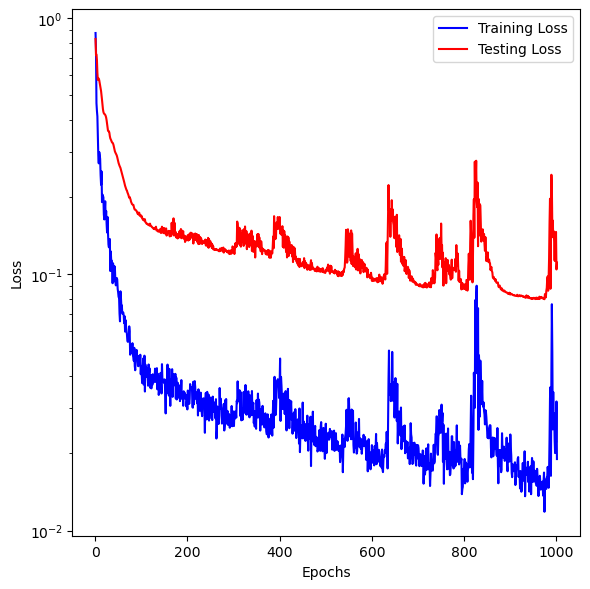

In [9]:
## Plotting the loss history
num_epoch = train_loss.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, train_loss[:,0], color='blue', label='Training Loss')
ax.plot(x, test_loss[:,0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

In [10]:
save_models_to = results_dir +"model/"
if not os.path.exists(save_models_to):
    os.makedirs(save_models_to)      

saver.save(sess, save_models_to+'Model')

np.savetxt(results_dir+'/train_loss.txt', train_loss)
np.savetxt(results_dir+'/test_loss.txt', test_loss)

data_save = SaveData()
data_save.save(sess, X_trunk_pos, fnn_model, W_T, b_T, W_B, b_B, X_trunk_min, X_trunk_max, X_ph, Y_ph, data, num_test, results_dir)

Relative L2 Error: 0.111


## Test and plot the output of network

In [11]:
X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
Y_test_pred = sess.run(Y_pred, feed_dict={X_ph: X_test})

error = np.mean(np.linalg.norm(Y_test_pred - Y_test, 2, axis=1)/np.linalg.norm(Y_test, 2, axis=1))

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2397, 1), test_pred shape: (100, 2397, 1)
Num tests:   100, Mean Loss (rel l2): 1.567e-01, Std Loss (rel l2): 0.000e+00


i_plot =     0, error (rel l2): 8.142e-02
i_plot =     1, error (rel l2): 9.876e-02
i_plot =     2, error (rel l2): 1.622e-01
i_plot =     3, error (rel l2): 1.387e-01
i_plot =     4, error (rel l2): 2.034e-01
i_plot =     5, error (rel l2): 7.824e-02
i_plot =     6, error (rel l2): 7.243e-02
i_plot =     7, error (rel l2): 7.404e-02
i_plot =     8, error (rel l2): 1.062e-01
i_plot =     9, error (rel l2): 8.288e-02
i_plot =    10, error (rel l2): 2.338e-01
i_plot =    11, error (rel l2): 1.152e-01
i_plot =    12, error (rel l2): 8.423e-02
i_plot =    13, error (rel l2): 1.132e-01
i_plot =    14, error (rel l2): 1.468e-01
i_plot =    15, error (rel l2): 1.304e-01


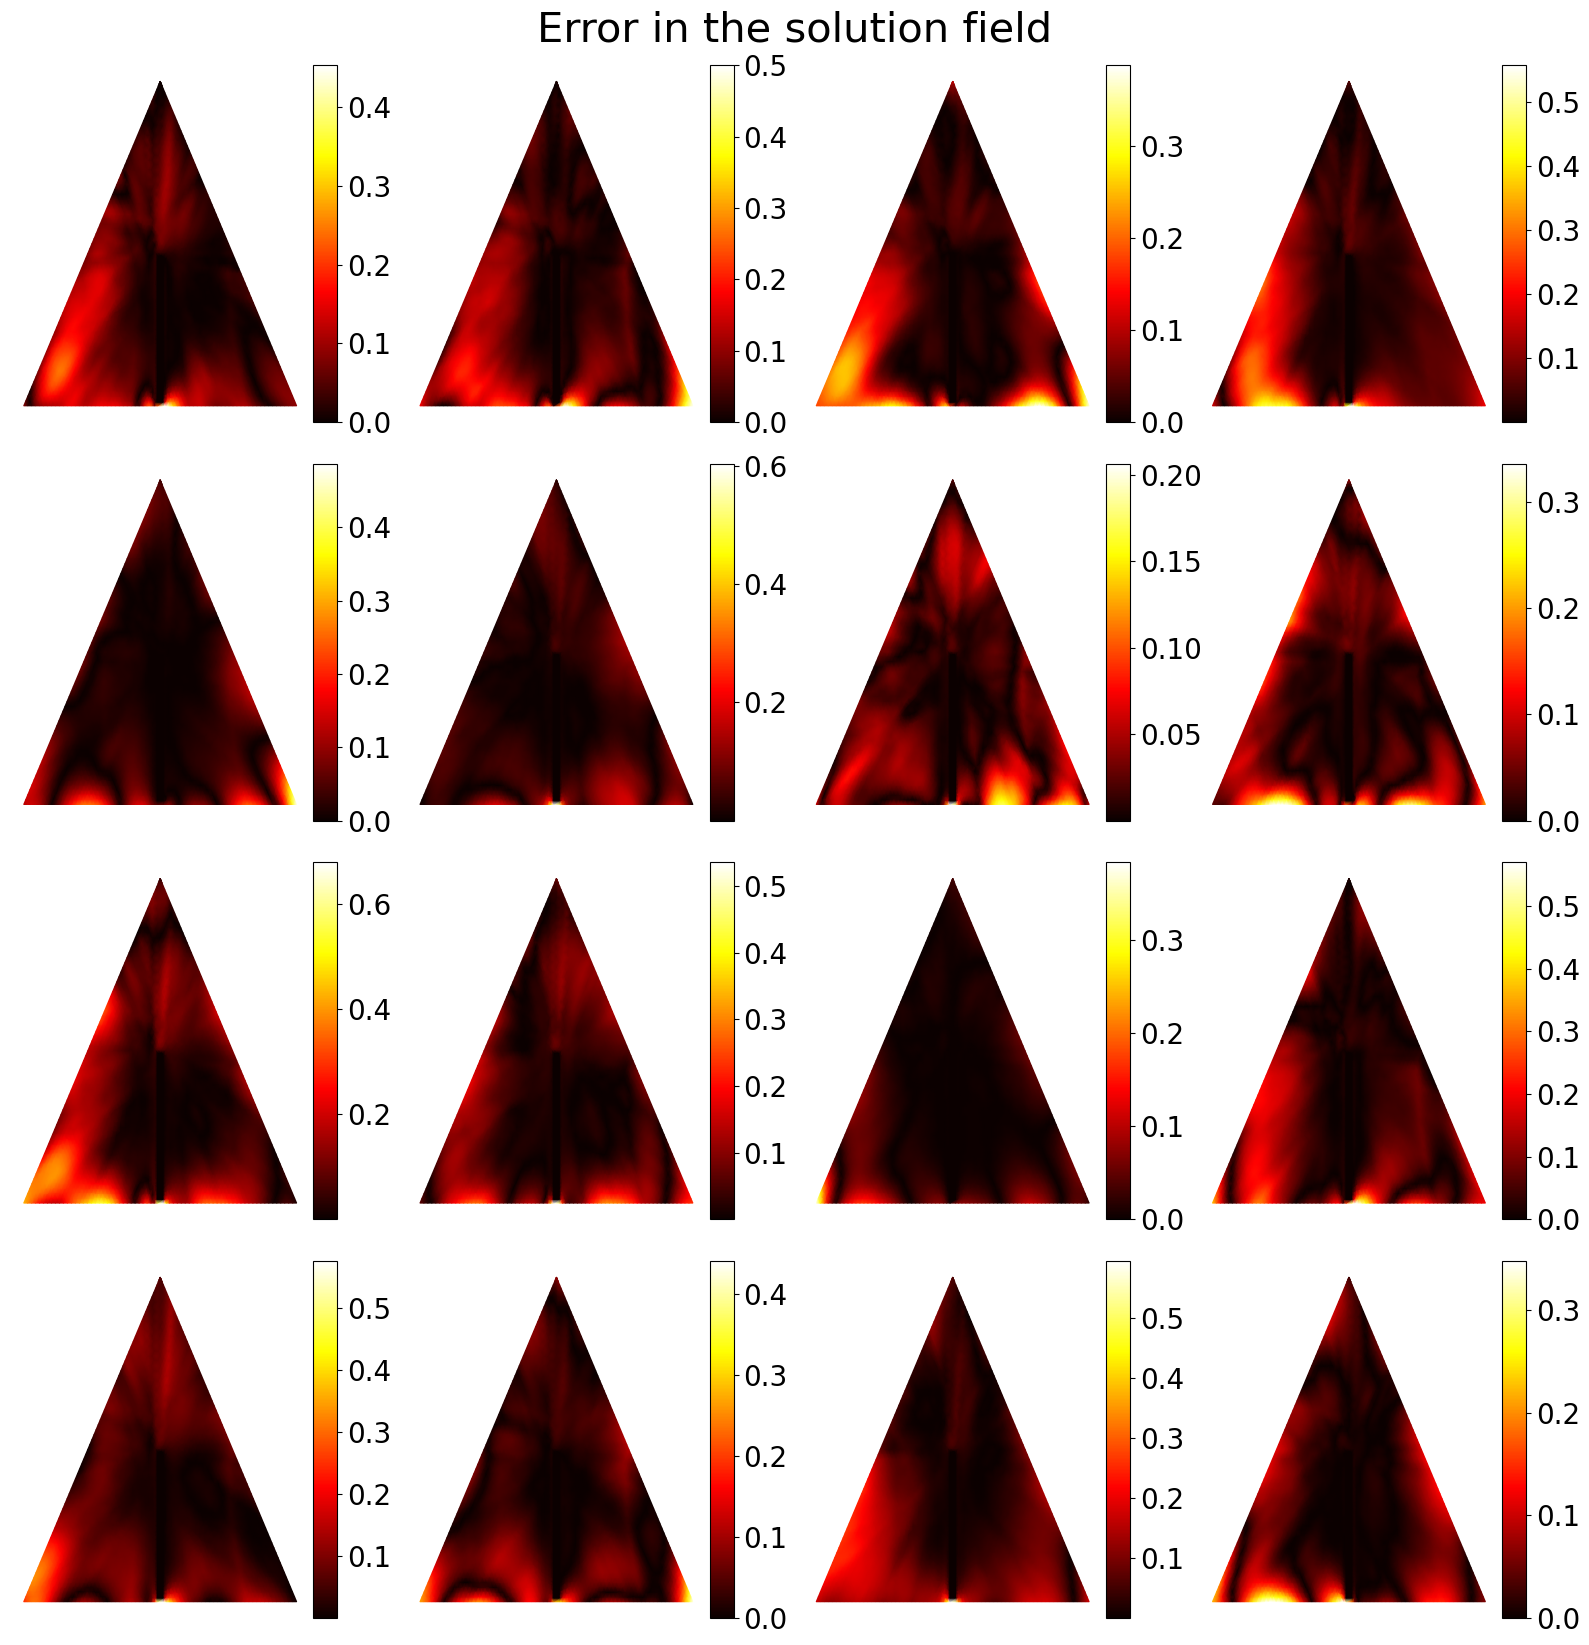

In [12]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))

decode = True

Y_spatial_points = data.X_trunk

for i in range(rows):
    for j in range(cols):
        i_plot = i*cols + j

        i_pred = Y_test_pred[i_plot, :, 0]
        i_truth = Y_test[i_plot, :, 0]
        if decode:
            i_pred = data.decoder_Y_1d(i_pred)
            i_truth = data.decoder_Y_1d(i_truth)
            
        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot(axs[i,j], i_diff, nodes, cmap = 'hot')

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    11, error (rel l2): 1.205e-01
i_plot =    35, error (rel l2): 8.517e-02
i_plot =    81, error (rel l2): 1.142e-01
i_plot =    36, error (rel l2): 1.433e-01


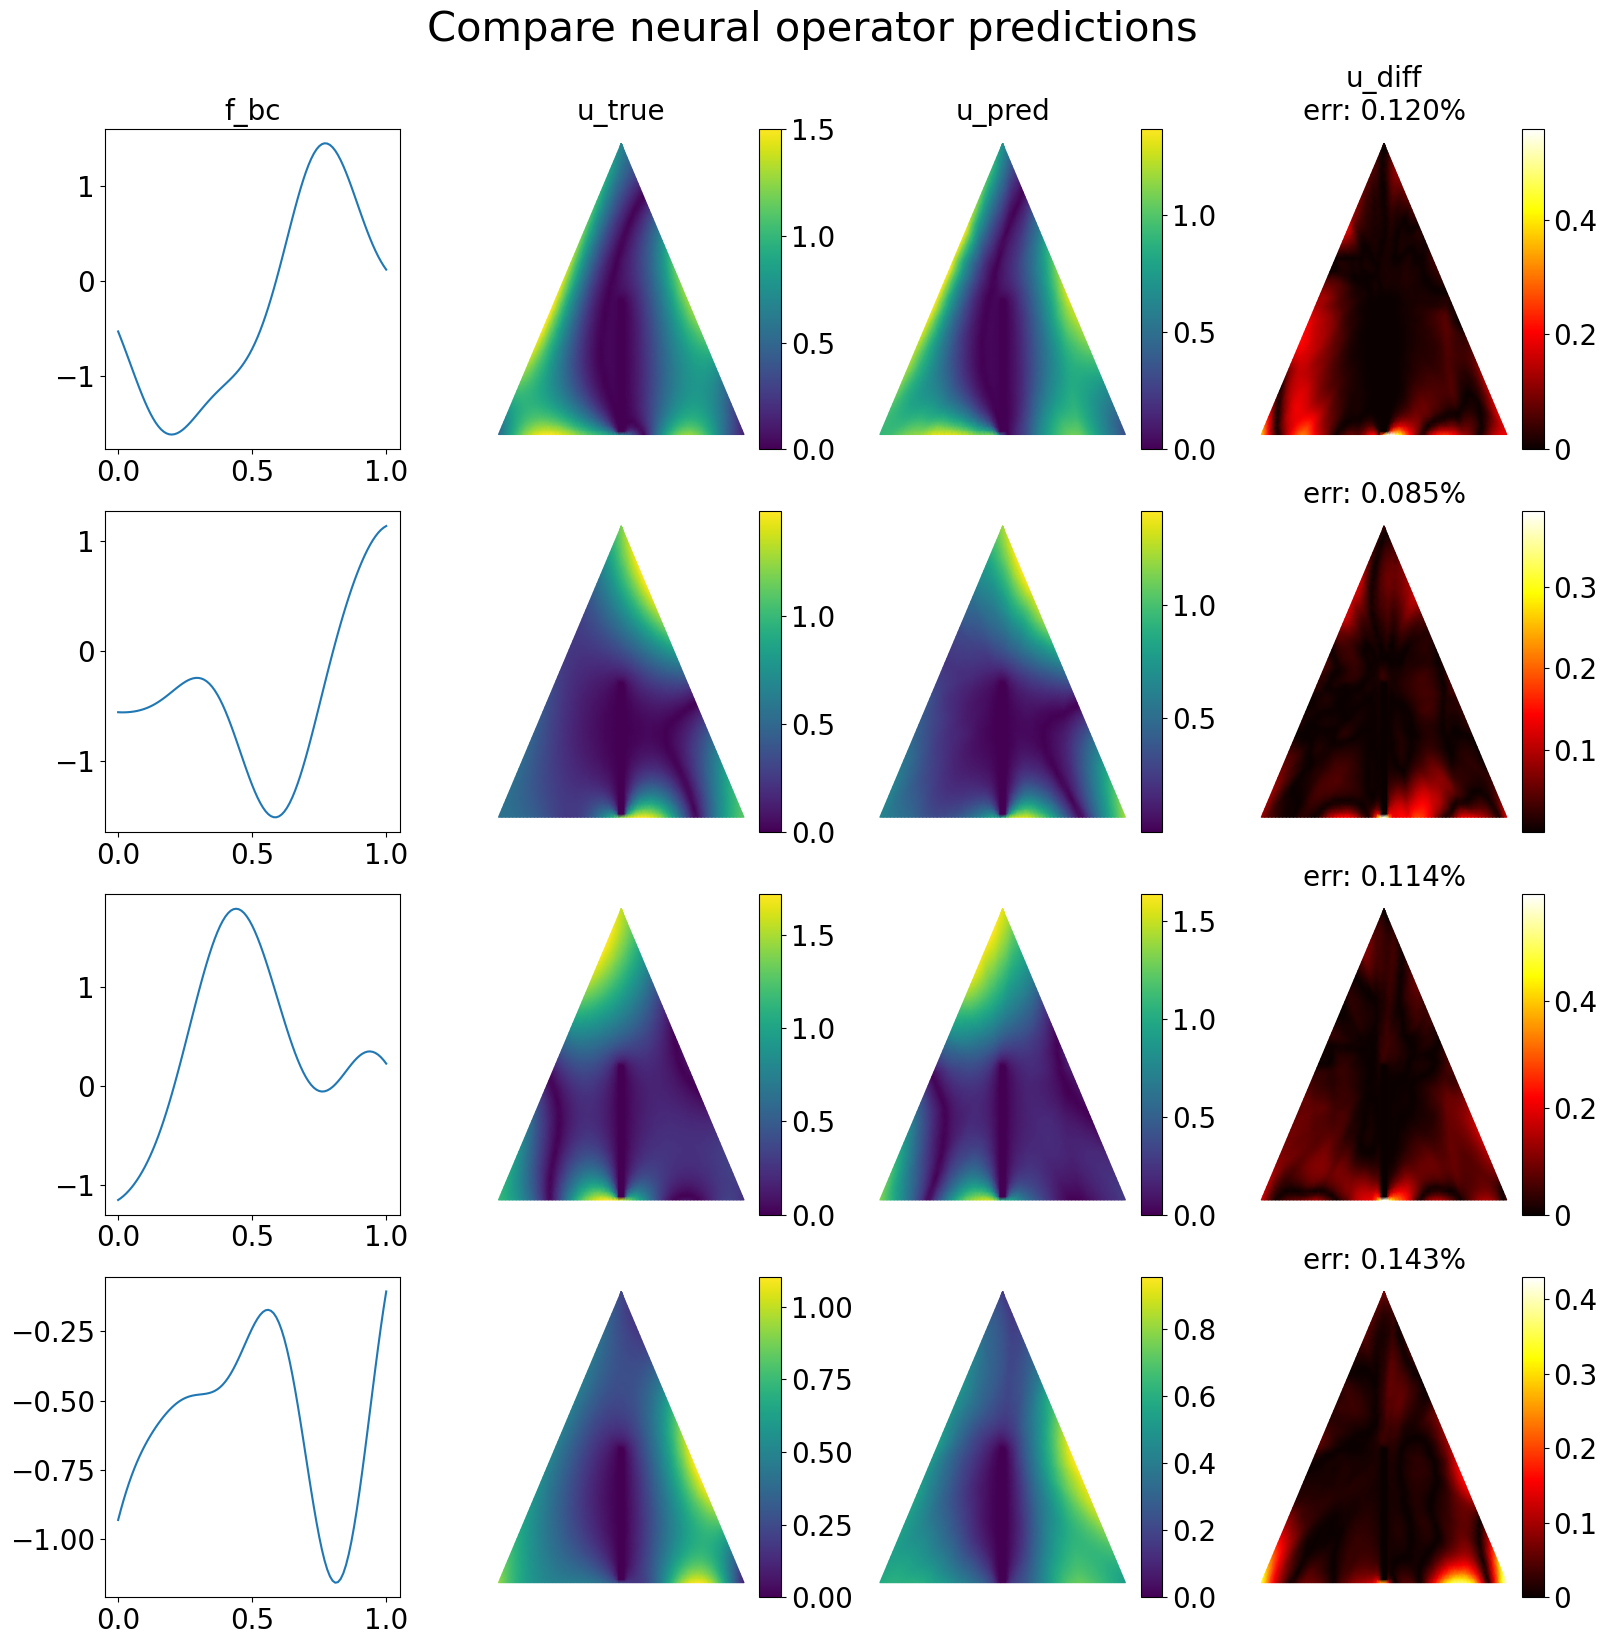

In [13]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))

decode = True

# row: m, u_true, u_pred, u_diff
u_tags = ['f_bc', 'u_true', 'u_pred', 'u_diff']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Y_spatial_points = data.X_trunk
X_spatial_points = np.linspace(0, 1, num_inp_fn_points)

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot, :, 0]
    i_truth = Y_test[i_plot, :, 0]
    i_m_test = X_test[i_plot, 0, :]
    if decode:
        i_pred = data.decoder_Y_1d(i_pred)
        i_truth = data.decoder_Y_1d(i_truth)
        i_m_test = data.decoder_X_1d(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j > 0:
            cbar = field_plot(axs[i,j], uvec[j], nodes, cmap = cmaps[j])

            divider = make_axes_locatable(axs[i,j])
            cax = divider.append_axes('right', size='8%', pad=0.03)
            cax.tick_params(labelsize=fs)

            if j == cols - 1:
                # format cbar ticks
                kfmt = lambda x, pos: "{:g}".format(x)
                
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
            else:
                cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

            axs[i,j].axis('off')
        else:
            axs[i,j].plot(nodes, uvec[j])
            axs[i,j].tick_params(labelsize=fs)


        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err: {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
